In [2]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [3]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [4]:
import seaborn as sns

In [5]:
import xgboost as xgb

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [7]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [8]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [9]:
df2 = df[df['MIC'] >= 1e-3]

In [10]:
df2

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
706,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131


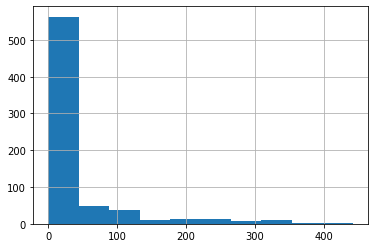

In [11]:
df2['MIC'].hist()

In [12]:
df2['pIC50'] = df2['MIC'].apply(lambda x: -np.log(x*1e-6))

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
706,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579


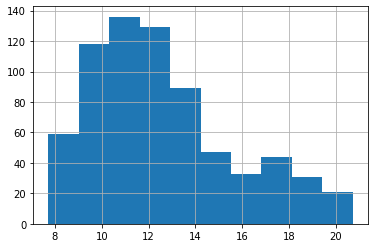

In [14]:
df2['pIC50'].hist()

In [16]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [21]:
aa_freq = reduce_by_kmer_frequency(df2, kmer=1)

In [22]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df2['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 707/707 [00:00<00:00, 1204.49sequence/s]


In [23]:
physicochemical_prop = get_physicochemical_properties(df2)

In [24]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [25]:
y = df2[['pIC50', 'MIC']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [29]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [37]:
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train_pmic)
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test_pmic)

In [109]:
param = {"booster":"dart", "objective":"reg:squarederror", "eval_metric":"rmse"}

In [112]:
xgb_r = xgb.train(params = param, dtrain = train_dmatrix, num_boost_round = 100)

In [113]:
y_pred_pmic = xgb_r.predict(test_dmatrix)

In [114]:
ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic

In [115]:
y_pred_mic = np.exp(-y_pred_pmic)/1e-6

In [116]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [117]:
list(zip(y_test_pmic.round(4), y_pred_pmic.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(13.7385, 12.4613, 9.296497003968982, 1.08, 3.8735, 258.6596912807888),
 (9.2103, 12.2336, 32.82447572255656, 100.0, 4.8643, 95.13569355010986),
 (9.2103, 10.6011, 15.099576633600828, 100.0, 24.8895, 75.1104564666748),
 (10.6128, 13.4773, 26.99127470830964, 24.6, 1.4025, 94.29895335096653),
 (11.7361, 12.9461, 10.310540930330772, 8.0, 2.3855, 70.18182873725891),
 (11.8554, 13.2203, 11.512368272710061, 7.1, 1.8135, 74.45782473389532),
 (11.2506, 14.6023, 29.79174487397189, 13.0, 0.4553, 96.49765858283409),
 (11.814, 12.8999, 9.19176192286294, 7.4, 2.4982, 66.24080877046327),
 (12.5627, 12.214, 2.776427071153874, 3.5, 4.9608, 41.73592158726284),
 (9.8191, 10.3455, 5.360317018849499, 54.4, 32.1376, 40.923522500430835),
 (10.232, 12.6371, 23.50604209045653, 36.0, 3.2491, 90.97467992040846),
 (10.2602, 10.4586, 1.934513979533228, 35.0, 28.699, 18.00273895263672),
 (12.8562, 12.4881, 2.8631398412544655, 2.61, 3.7714, 44.49718811502859),
 (11.4176, 11.0, 3.65724761295427, 11.0, 16.701, 51.82

In [118]:
mean_squared_error(y_test_pmic, y_pred_pmic)**0.5

1.9580836442788954

In [119]:
r2_score(y_test_pmic, y_pred_pmic)

0.4901653650180381

In [121]:
import matplotlib.pyplot as plt

In [126]:
%matplotlib

Using matplotlib backend: MacOSX


In [127]:
xgb.plot_importance(xgb_r)

### hyperparam tuning

In [128]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [129]:
hyperParameterTuning(X_train, y_train_pmic)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.3min finished


{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [130]:
best_params = {'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [132]:
xgb_model = xgb.XGBRegressor(**best_params)

In [134]:
xgb_model.fit(X_train, y_train_pmic, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [138]:
y_pred_pmic = xgb_model.predict(X_test)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


In [140]:
ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic

In [141]:
y_pred_mic = np.exp(-y_pred_pmic)/1e-6

In [142]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [143]:
list(zip(y_test_pmic.round(4), y_pred_pmic.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(13.7385, 12.8988, 6.112276812537825, 1.08, 2.501, 131.57607626031947),
 (9.2103, 12.1159, 31.546806452518677, 100.0, 5.4718, 94.52823162078857),
 (9.2103, 10.7414, 16.623079767596764, 100.0, 21.631, 78.36898994445801),
 (10.6128, 11.5531, 8.860779849789234, 24.6, 9.6059, 60.95180899147096),
 (11.7361, 12.3181, 4.9593510897263, 8.0, 4.4701, 44.12387013435364),
 (11.8554, 12.0443, 1.593634443088761, 7.1, 5.8777, 17.215723386952572),
 (11.2506, 13.6047, 20.925008163707986, 13.0, 1.2346, 90.50287283383884),
 (11.814, 13.0505, 10.466052856031784, 7.4, 2.149, 70.95903190406592),
 (12.5627, 11.0751, 11.841593679997072, 3.5, 15.4931, 342.6590238298689),
 (9.8191, 10.2454, 4.341331350825693, 54.4, 35.5195, 34.70675805035759),
 (10.232, 11.4435, 11.840848983377965, 36.0, 10.7184, 70.2265977859497),
 (10.2602, 10.9855, 7.069281014366869, 35.0, 16.9459, 51.58302852085659),
 (12.8562, 11.7295, 8.763822228500892, 2.61, 8.053, 208.5430189110767),
 (11.4176, 11.1143, 2.6565908739921196, 11.0, 14.897

In [144]:
mean_squared_error(y_test_pmic, y_pred_pmic)**0.5

1.998697085322193

In [145]:
r2_score(y_test_pmic, y_pred_pmic)

0.46879663917936976